In [1]:
import mne
import numpy as np
import pandas as pd
from pandas import Series
from scipy import stats
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import mne.io 
import scipy
from mne.stats import permutation_cluster_1samp_test
from mne.stats import spatio_temporal_cluster_1samp_test
from mne.stats import permutation_cluster_test
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from mne.stats import summarize_clusters_stc
import pingouin as png
np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Neuronal data must be in format rows - people, columns - channels
# Correct type of data format can be obtained with 'Prepare for cluster test'

In [31]:
# functions that return corr size
def cor_r(dat, beh):
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        rho[i],pval[i]=stats.spearmanr(dat[:,i],beh, nan_policy='omit')
    return np.array(rho)

# returns p-value
def cor_p(dat, beh):
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        rho[i],pval[i]=stats.spearmanr(dat[:,i],beh, nan_policy='omit')
    return np.array(pval)

# main function for cluster test: computes spearman correlation and returns rho t statistics
def get_t(data):
    t_stat=[0]*nsrc
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        rho[i],pval[i]=stats.spearmanr(data[:,i],beh, nan_policy='omit')
        t_stat[i]=rho[i]*(np.sqrt(data.shape[0]-2))/np.sqrt((1-rho[i]*rho[i]))
    return np.array(t_stat)

# partial corr functions
import pingouin as png
def cor_r_partial(data):
    rho=[0]*nsrc
    for i in range (nsrc):
        df = pd.DataFrame(index=range(0,len(beh)), data={'beh': beh, 'neuro': neuro[:,i], 'sex': dat['pcqI02an']})
        rho[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['r'][0]
    return np.array(rho, dtype='float')

# returns p-value
def cor_p_partial(data):
    pval=[0]*nsrc
    for i in range (nsrc):
        df = pd.DataFrame(index=range(0,len(beh)), data={'beh': beh, 'neuro': neuro[:,i], 'sex': dat['pcqI02an']})
        pval[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['p-val'][0]
    return np.array(pval, dtype='float')

def get_t_partial(data):
    t_stat=[0]*nsrc
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        df = pd.DataFrame(index=range(0,len(beh)), data={'beh': beh, 'neuro': neuro[:,i], 'sex': dat['pcqI02an']})
        pval[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['p-val'][0]
        rho[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['r'][0]
        t_stat[i]=rho[i]*(np.sqrt(data.shape[0]-2))/np.sqrt((1-rho[i]*rho[i]))
    return np.array(t_stat)

In [33]:
## set configurationa and load data for cluster test 
# the data should be in format (rows=individuals, columns=activity_sources+behavioral data)
# !!! the sequence of channels in the data must be the same as in connectivity matrix, 
# !!! the following columns are behavioral data

# set path
#main_dir = 'H:/IQ-2(Chb-Msk)/Cl_Test/'
main_dir = '/Volumes/One Touch/Barracuda/Autoreject/'
out_dir = main_dir+'Cl_Test/'

# set data loading configurations
# sensor space or source space
level = 'PCA' 
# type of neuronal data 
datatype = 'lrtc'
# number of sources
nsrc = 68
# frequency boundaries
l_freq = 8 # low frequency 
h_freq = 12 # high frequency
freq = str(l_freq)+'_'+str(h_freq)
# sex: also can be male or female or all
sex = 'all'

# load data
dat = pd.read_csv(out_dir+level+'_'+datatype+'_'+freq+'_'+sex+'.csv')
n_subjects = dat.shape[0]

# choose data
# neuronal data for each participant for each channel, lrtc\power\etc.
neuro = np.array(dat.iloc[:,0:nsrc], dtype=float) 
# behavioral data but you can only use 1 variable for cluster permutation test
# so find out which number of behavioral data column to fetch from dataframe
# with which you want to test the correlations
ntask =70
beh = np.array(dat.iloc[:,ntask], dtype=float) 
# name of the task
taskstr =  dat.columns[ntask] 

# load source_neighbours information about connectivity
matrixx = pd.read_csv(out_dir+'sources_neighbours_matrix.csv', index_col=0)
connectivity = scipy.sparse.csr_matrix(matrixx.values)

print('Data type:', datatype)
print('N subjects:', n_subjects)
print('N sensors:', neuro.shape[1])
print('Frequecy band:', freq)
print('Cognitive task:', taskstr)

Data type: lrtc
N subjects: 105
N sensors: 68
Frequecy band: 8_12
Cognitive task: pcpvtot.x


In [34]:
## briefly run simple Spearcman correlation: is there any corrrelation at all?

# set the p value threshold to find out which correlations are significant
p_threshold = 0.05
tr = str(p_threshold)
tr = tr.replace(".", "")
# compute t-statistic threshold for cluster test
t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects - 1)

rho=cor_r(neuro, beh)
pval=cor_p(neuro, beh)

# check which of the correlations are significant
true_cor=pval<=p_threshold
print(true_cor)
rho_max=max(rho)
rho_min=min(rho)# can be used to plot the association 
print(rho_max, rho_min)

[False False  True False False False False  True False  True False False
  True False False False  True False  True False  True  True False  True
  True False False False False False  True  True False  True False False
 False False  True False False False False  True  True  True  True False
 False False False  True False False False False False False  True  True
 False False False  True  True False  True  True]
0.2911284678712149 0.043981160288571124


In [35]:
# partial correlartion test
rho=cor_r_partial(neuro)
pval=cor_p_partial(neuro)

# check which of the correlations are significant
true_cor=pval<=p_threshold
print(true_cor)
rho_max=max(rho)
rho_min=min(rho)# can be used to plot the association 
print(rho_max, rho_min)

[False False  True False False False  True  True False  True False False
  True False False False  True False  True False  True False False  True
  True False False False False  True  True  True False False False False
 False False  True False False False False  True  True  True  True False
 False False False False False False False False False False False False
 False False False  True  True False  True  True]
0.28845530424204113 0.04575421355210026


In [37]:
# FDR correction for pvalues: just to check
from mne.stats import fdr_correction
rejects, pvalues = fdr_correction(pval, alpha=0.05)
print('Recects:', rejects)
print('New p-val:', pvalues)
adjusted=pvalues<=p_threshold


Recects: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
New p-val: [0.17143588 0.1423826  0.13838912 0.1567901  0.20216917 0.19967632
 0.13838912 0.13838912 0.1423826  0.13838912 0.19423728 0.19423728
 0.13838912 0.1567901  0.18125599 0.18344884 0.13838912 0.18635719
 0.13838912 0.16906443 0.13838912 0.13838912 0.1567901  0.13838912
 0.13838912 0.19423728 0.1567901  0.15457731 0.19423728 0.13838912
 0.13838912 0.13838912 0.15306675 0.13838912 0.13838912 0.18754142
 0.31590554 0.1567901  0.13838912 0.20095938 0.24735358 0.24735358
 0.1567901  0.13838912 0.13838912 0.13838912 0.13838912 0.1567901
 0.13838912 0.13838912 0.14238

In [38]:
# Run cluster test
t_obs, clusters, cluster_pv, H0 = clu = permutation_cluster_1samp_test(neuro, threshold=t_threshold, n_permutations = 1000, 
                                                                       stat_fun = get_t, adjacency=connectivity, 
                                                                       verbose = None, buffer_size = None, out_type = 'mask')


stat_fun(H1): min=0.446792 max=3.088409
Running initial clustering
Found 6 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [84]:
cluster_pv

array([0.177, 0.245, 0.496, 0.489, 0.458])

In [89]:
# Check significant clusters 
good_cluster_inds = np.where(cluster_pv < 0.05)[0]
gclpv = cluster_pv[good_cluster_inds[0]]
print("Clusters, significant at", gclpv)
print(good_cluster_inds)
clpv = str(gclpv).replace(".", "")

Clusters, significant at 0.036
[0 1]


In [90]:
# load labels to adequately save for visualisation
labels = mne.read_labels_from_annot('fsaverage')
labels = labels[:-1]
label_names = [label.name for label in labels]

Reading labels from parcellation...
   read 35 labels from C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot


In [91]:
# create a mask of clusters to save the results
bools = [False]*nsrc
sources = np.array(range(0,nsrc))
for i in range(0,len(clusters)):
    if i in good_cluster_inds:
        for n in range(0,len(sources[clusters[i]])):
            bools[sources[clusters[i]][n]] = True
    elif i not in good_cluster_inds:
        for n in range(0,len(sources[clusters[i]])):
            bools[sources[clusters[i]][n]] = False
            


In [92]:

    
# arrange significant clusters info
ch_names = label_names
#test = np.array(range(0,nsrc))
zeros = [0]*nsrc
df = pd.DataFrame({'cluster' : bools, 'neuro' : zeros, 'rho' : rho, 'ch_names' : ch_names})
for i in range(0,nsrc):
    if df.iloc[i,0] == True:
        df.iloc[i,1] = df.iloc[i,2]
        
print(df)

# choose only the activation info
#t = pd.DataFrame(df['neuro'])
# save
type(df)
df.to_csv('H:/Autoreject/Cl_Test/Final/PCA_'+str(datatype)+'_'+str(taskstr)+'_'+str(freq)+'_'+str(tr)+'_'+str(clpv)+'_'+str(sex)+'.csv', sep = ',', index = False)

    cluster     neuro       rho                     ch_names
0     False  0.000000  0.169950                  bankssts-lh
1      True  0.226945  0.226945                  bankssts-rh
2      True  0.203824  0.203824   caudalanteriorcingulate-lh
3      True  0.206541  0.206541   caudalanteriorcingulate-rh
4     False  0.000000  0.121244       caudalmiddlefrontal-lh
5     False  0.000000  0.155440       caudalmiddlefrontal-rh
6      True  0.228041  0.228041                    cuneus-lh
7      True  0.255396  0.255396                    cuneus-rh
8     False  0.000000  0.110102                entorhinal-lh
9     False  0.000000  0.144384                entorhinal-rh
10    False  0.000000  0.062393               frontalpole-lh
11    False  0.000000  0.118285               frontalpole-rh
12    False  0.000000  0.169492                  fusiform-lh
13     True  0.206597  0.206597                  fusiform-rh
14     True  0.270927  0.270927          inferiorparietal-lh
15     True  0.273441  0

0.003971504246145164


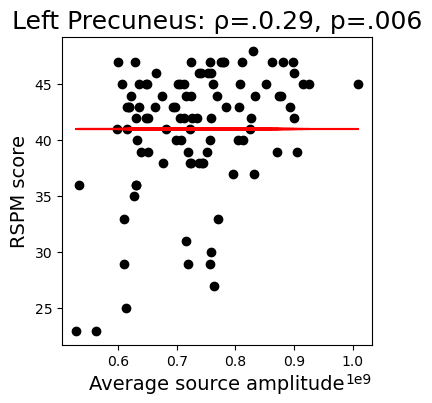

In [40]:

# slope intercept function
def slope_intercept(x_val,y_val):
    x=np.array(x_val)
    y=np.array(y_val)
    m=(((np.nanmean(x)*np.nanmean(y)) - np.nanmean(x*y)) / ((np.nanmean(x)*np.nanmean(x)) - np.nanmean(x*x)))
    m=round(m,2)
    b=(np.nanmean(y)-np.nanmean(x)*m)
    b=round(b,2)
    
    return m,b

# find max rho in results
max_value = max(rho)
max_index = list(rho).index(max_value)
neuro_reg = neuro[:,max_index]
print(pval[max_index])
neuro_reg = neuro[:,max_index]*1000000000
# choose channel for visualization
m,b=slope_intercept(neuro_reg, beh)
# visualize slope line
reg_line=[(m*x)+b for x in neuro_reg]

fig, ax = plt.subplots()
#print(reg_line)
#plt.axis([0, 0.000007, 0, 30])
   
plt.scatter(neuro_reg, beh, c='Black')
plt.plot(neuro_reg, reg_line, c='red')
plt.ylabel("RSPM score", fontsize=14)
plt.xlabel("Average source amplitude", fontsize=14) #lrtc(\u03B1) power((\u03BCV))
#plt.text(3, 4, 'Random Noise', style='italic', fontsize=12,
 #       bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
plt.title("Left Precuneus: \u03C1=."+str(round(max_value,2))+", p=.006", fontsize=18)
#plt.figure(figsize=(1,1))
plt.rcParams["figure.figsize"] = (4,4)
plt.show()    

In [ ]:
# another way to save data - separately for left and righ hemisphere
lh_dat = df.iloc[::2, :]
rh_dat = df.iloc[1::2, :]
print(rh_dat)

#lh_save = pd.DataFrame(lh_dat['neuro'])
#rh_save = pd.DataFrame(rh_dat['neuro'])
# save
lh_dat.to_csv(out_filename+'lh'+str(taskstr)+'_'+str(freq)+'_'+str(tr)+'_'+str(clpv)+'.csv', sep = ',', index = False)
rh_dat.to_csv(out_filename+'rh'+str(taskstr)+'_'+str(freq)+'_'+str(tr)+'_'+str(clpv)+'.csv', sep = ',', index = False)

In [ ]:
# cluster illustration DO NOT TRY IT 
fwd_sol = mne.read_forward_solution(fwd_dir)
src = fwd_sol['src']

#dat =  np.genfromtxt('D:/Ann/Sourse-Reconstruction/Cl_Test/clust_src_pv_810_005_0039.csv', skip_header=1)
dat = np.genfromtxt(out_filename+str(freq)+'_'+str(tr)+'_'+str(clpv)+'.csv', skip_header=1)
vertices = [src[0]['vertno'], src[1]['vertno']]
stc_new = mne.SourceEstimate(dat, vertices, tmin=0, tstep=1 / sf)

filename = out_filename+str(taskstr)+'_'+str(freq)+'_'+str(tr)+'_'+str(clpv)+'.csv'
print(filename)

clim = dict(kind='value', pos_lims=[0, max(stc_new.data)/2, max(stc_new.data)])
stc_new.plot(subject='fsaverage', subjects_dir=subjects_dir, clim=clim, time_viewer=True, hemi='both', surface='pial') #lat med dor
#test.save('D:/Ann/Sourse-Reconstruction/Viz/Viz_LRTC/clust_src_pv_'+str(freq)+'_'+str(tr)+'_'+str(clpv)+'.png')